In [1]:
'''
Evaluation metrics for AEC systems
'''

import torch
import os
import math

import numpy as np
import soundfile as sf
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.signal import welch
from scipy.signal.windows import hann

from scipy.signal import csd
from scipy.signal import welch

# ---------------------- Coherence ----------------------------------- #
def mscohere(audio_data1, audio_data2, sample_rate, segment_length = 1024) :
    # Choose window function and overlap length
    window = 'hamming'  # You can choose other window functions if needed
    overlap = 0.5  # Overlap as a fraction of the segment length

    # Calculate the power spectral density of the individual signals using Welch's method
    freq1, psd1 = welch(audio_data1, fs=sample_rate, window=window, nperseg=segment_length, noverlap=int(segment_length * overlap))
    freq2, psd2 = welch(audio_data2, fs=sample_rate, window=window, nperseg=segment_length, noverlap=int(segment_length * overlap))

    # Compute the cross spectral density using Welch's method
    frequencies, csd_value = csd(audio_data1, audio_data2, fs=sample_rate, window=window, nperseg=segment_length, noverlap=int(segment_length * overlap))

    # print(csd_value)
    # Calculate the coherence from the cross spectral density
    coherence = (csd_value * np.conjugate(csd_value)) / (psd1 * psd2)

    return coherence, frequencies

# ------------------------------ ERLE ------------------------------ #

def compute_erle(mic_sig, aec_sig, fs, save_plt=False, filename=None):
    '''
    Computes the Echo Return Loss Enhancement

    Args:
        mic_sig (array): microphone signal array (samples * 1)
        aec_sig (array): acoustic echo canceller output signal array (samples * 1)
        fs (int): Sampling Rate (in Hz)
        save_plt (bool): if True the plots are saved
        filename (string): filename to be atted to the saved plots (without extension)

    Returns:
        erle_avg: average erle
        erle: sample based erle
    '''

    # check if one channel
    if len(mic_sig.shape) != 1:
        raise TypeError('Only single channel is supported')

    # compute input and output energies on a sample basis

    #   make files of the same size
    min_len = min(mic_sig.shape[0], aec_sig.shape[0])
    mic_sig = mic_sig[:min_len]
    aec_sig = aec_sig[:min_len]
    #   initialize erle scores and energies
    erle = np.zeros((min_len,))
    mic_eng = 0
    aec_eng = 0
    eps=1e-20
    smooth_val = 0.9999

    for indx, (mic_sample, aec_sample) in enumerate(zip(mic_sig, aec_sig)):
        mic_eng = smooth_val * mic_eng + (1 - smooth_val) * (mic_sample ** 2)
        aec_eng = smooth_val * aec_eng + (1 - smooth_val) * (aec_sample ** 2)
        erle[indx] = (mic_eng+eps)/(aec_eng+eps)

    erle_avg = 10*np.log10(erle[np.nonzero(erle)]+eps)
    erle_avg = erle_avg.mean()

    # plot the result
    fig1, ax1 = plt.subplots()
    time = np.divide(np.array(range(min_len)), fs)
    ax1.plot(time, 10*np.log10(erle+1e-20))
    ax1.set_title('Average ERLE score: {}'.format(erle_avg))
    ax1.set_xlabel('time (sec)')
    ax1.set_ylabel('ERLE (dB)')
    ax1.grid(1)
    ax1.set_xlim(0, time[-1])
    ax1.set_ylim(-5, 100)
    if save_plt:
        filepath = os.path.join(plots_dir, 'erle_vikas_td_' + filename)
        try:
            fig1.savefig(filepath)
        except:
            print('if you want to save your plots then specify a filename')

    # frequency domain ERLE
    nfft = 512
    hop = 128
    # compute the periodograms
    f, Pyy = welch(mic_sig[math.floor(min_len/2):],
                   fs=fs,
                   window=hann(nfft),
                   noverlap=hop,
                   nfft=nfft,
                   return_onesided=True,
                   detrend=False)
    f, Pxx = welch(aec_sig[math.floor(min_len/2):],
                   fs=fs,
                   window=hann(nfft),
                   noverlap=hop,
                   nfft=nfft,
                   return_onesided=True,
                   detrend=False)
    erle_freq = 10*np.log10(Pyy) - 10*np.log10(Pxx)
    erle_freq = smooth_val * erle_freq + (1.0 - smooth_val) * erle_freq

    # plot the result
    fig2, ax2 = plt.subplots()
    ax2.semilogx(f, erle_freq)
    ax2.set_title('ERLE score - periodogram')
    ax2.set_xlabel('frequency (Hz)')
    ax2.set_ylabel('ERLE (dB)')
    ax2.grid(1)
    ax2.set_xlim(0, f[-1])
    if save_plt:
        filepath = os.path.join(plots_dir, 'erle_vikas_fd_' + filename)
        fig2.savefig(filepath)

    return erle_avg, erle, erle_freq, f

def compute_erle_silero(mic_sig, aec_sig, fs=48000, save_plt=False, filename=None):
    '''
    Compute Echo Return Loss Enhancement using Silero VAD to detect the segments of the input signals conatining speech
    Silero VAD: https://github.com/snakers4/silero-vad

    Args:
        mic_sig (array): microphone signal array (samples * 1)
        aec_sig (array): acoustic echo canceller output signal array (samples * 1)
        fs (int): Sampling Rate (in Hz)
        save_plt (bool): if True the plots are saved
        filename (string): filename to be atted to the saved plots (without extension)

    Returns:
        erle_avg: average erle
        erle: sample based erle
    '''
    output_directory = './output'
    plots_dir = os.path.join(output_directory, 'plots')
    if not os.path.isdir(output_directory):
        print("Creating output directory {}".format(output_directory))
        os.makedirs(output_directory, exist_ok=True)
    if save_plt:
        mpl.rcParams['lines.linewidth'] = 0.5

        if not os.path.isdir(plots_dir):
            print("Creating output directory {}".format(plots_dir))
            os.makedirs(plots_dir, exist_ok=True)

    # load pretrained Silero VAD
    model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)
    (get_speech_ts,
    _, _, read_audio,
    _, _, _) = utils

    # check if one channel
    if len(mic_sig.shape) != 1:
        raise TypeError('Only single channel is supported')

    # make files of the same size
    min_len = min(mic_sig.shape[0], aec_sig.shape[0])
    mic_sig = mic_sig[:min_len]
    aec_sig = aec_sig[:min_len]

    # run VAD
    speech_timestamps = get_speech_ts(torch.tensor(mic_sig), model, num_steps=4)
    # create VAD mask

    mask = np.zeros((min_len, 1))
    for idx, timestamp in enumerate(speech_timestamps):
        split = range(timestamp['start'], timestamp['end'])
        mask[list(split)] = 1

    # compute ERLE on segment where voice is detected and on a sample basis
    erle = np.zeros((min_len,))
    mic_eng = 0
    aec_eng = 0
    eps=1e-20
    smooth_val = 0.9999

    for indx, (mic_sample, aec_sample) in enumerate(zip(mic_sig, aec_sig)):
        mic_eng = smooth_val * mic_eng + (1 - smooth_val) * (mic_sample ** 2)
        aec_eng = smooth_val * aec_eng + (1 - smooth_val) * (aec_sample ** 2)
        erle[indx] = (mask[indx] * (mic_eng+eps))/(aec_eng+eps)

    erle_avg = 10*np.log10(erle[np.nonzero(erle)]+eps)
    erle_avg = erle_avg.mean()

    # plot the result
    fig1, ax1 = plt.subplots()
    time = np.divide(np.array(range(min_len)), fs)
    ax1.plot(time, 10*np.log10(erle+1e-20))
    ax1.set_title('Average ERLE score {:.4f} dB'.format(erle_avg))
    ax1.set_xlabel('time (sec)')
    ax1.set_ylabel('ERLE (dB)')
    ax1.grid(1)
    ax1.set_xlim(0, time[-1])
    ax1.set_ylim(-5, 100)
    if save_plt:
        filepath = os.path.join(plots_dir, 'erle_silero_td_' + filename)
        try:
            fig1.savefig(filepath)
        except:
            print('if you want to save your plots then specify a filename')

    return erle_avg, erle


In [3]:
# Dataset to toy with:
"""
https://github.com/microsoft/AEC-Challenge/tree/main/datasets/test_set_icassp2022/doubletalk
Download these files:
00113069-3e44-460a-be8d-9c252979a801_doubletalk_mic.wav
00113069-3e44-460a-be8d-9c252979a801_doubletalk_lpb.wav


https://github.com/microsoft/AEC-Challenge/tree/main/datasets/real
Download these files:
-0AcvGNEdEK-DQGxWmtq2Q_farend_singletalk_lpb.wav
-0AcvGNEdEK-DQGxWmtq2Q_farend_singletalk_mic.wav

https://github.com/microsoft/AEC-Challenge/blob/main/datasets/blind_test_set_icassp2023/doubletalk
Download these files:
00t5hG031EmZTpJtcnhS0g_doubletalk_mic.wav
00t5hG031EmZTpJtcnhS0g_doubletalk_lpb.wav


Anything with mic is basically d -> Dirty Signal
Anything with a filename lpb is basically x -> Reference Signal

Note: lpb stands for loop playback
      since we are looping the playback between the microphone and the

"""
import librosa
# Crappy Recording
# d, sr_d = librosa.load("-0AcvGNEdEK-DQGxWmtq2Q_farend_singletalk_mic.wav", sr = 48000)
# x, sr_x = librosa.load("-0AcvGNEdEK-DQGxWmtq2Q_farend_singletalk_lpb.wav", sr = 48000)

# d, sr_d = librosa.load("00113069-3e44-460a-be8d-9c252979a801_doubletalk_mic.wav", sr = 48000)
# x, sr_x = librosa.load("00113069-3e44-460a-be8d-9c252979a801_doubletalk_lpb.wav", sr = 48000)

d, sr_d = librosa.load("00t5hG031EmZTpJtcnhS0g_doubletalk_mic.wav", sr = 48000)
x, sr_x = librosa.load("00t5hG031EmZTpJtcnhS0g_doubletalk_lpb.wav", sr = 48000)

assert sr_x == sr_d, "Sampling rates of the input files do not match."
sr = sr_x

delay = 2512
delay2 = 2513

# Grab only first 10 seconds (Single-Talk Case)
d_1 = d[(1*sr_d):(11*sr_d)]
x_1 = x[(1*sr_d - delay):(11*sr_x - delay)]
# 2512 samples was found for synchronicity
print("x_1 & d_1 are your Single-Talk Scenerios")

# Grab last 10 seconds ish (Double-Talk Case)
d_2 = d[(27*sr_d):(37*sr_d)]
x_2 = x[(27*sr_x - delay2):(37*sr_x - delay2)]
print("x_2 & d_2 are your Double-Talk Scenerios")

# Create Single Talk & Double Talk Folders if doesn't exist
import os

# Specify the directory path
directories = ["./single_talk", "./double_talk"]

for directory in directories:
    # Check if the directory exists
    if not os.path.exists(directory):
        # Create the directory
        os.makedirs(directory)
        print(f"Directory '{directory}' created.")
    else:
        print(f"Directory '{directory}' already exists.")

x_1 & d_1 are your Single-Talk Scenerios
x_2 & d_2 are your Double-Talk Scenerios
Directory './single_talk' created.
Directory './double_talk' created.


In [4]:
# Single-Talk Case (Near-End ~= 0/Environment Noise, Far-End = x_1)
sf.write('mic.wav', d_1, sr, subtype='PCM_16')
sf.write('ref.wav', x_1, sr, subtype='PCM_16')

# Double-Talk Case (Near-End ~= Speech, Far-End = x_1)
sf.write('mic2.wav', d_2, sr, subtype='PCM_16')
sf.write('ref2.wav', x_2, sr, subtype='PCM_16')

In [ ]:
import numpy as np
from scipy.signal import correlate
import seaborn as sns

signal1 = d_2
signal2 = x_2

# Compute cross-correlation
correlation = correlate(signal1, signal2)

# Find the index of the maximum correlation
max_corr_index = np.argmax(correlation)

# Calculate the delay
delay = max_corr_index - (len(signal1) - 1)

print(f"The delay between the two signals is {delay} samples.")

The delay between the two signals is 0 samples.


<ipython-input-107-8caf709e6e16>:12: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, correlation, basefmt=" ", use_line_collection=True)


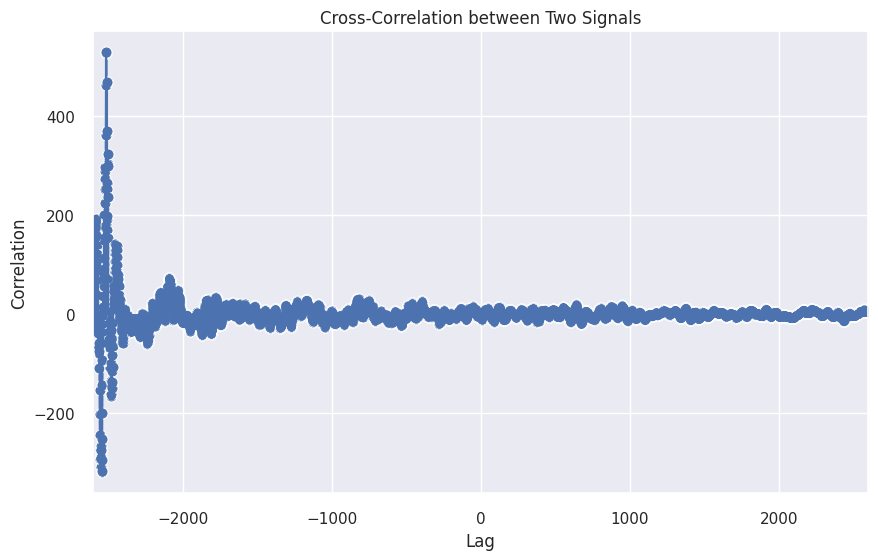

In [ ]:

# Create lags array
lags = np.arange(-len(signal1) + 1, len(signal2))

# Plot the correlation using seaborn
sns.set(style="darkgrid")

plt.figure(figsize=(10, 6))
sns.lineplot(x=lags, y=correlation, marker='o', linestyle='-', markersize=8)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Cross-Correlation between Two Signals')
plt.stem(lags, correlation, basefmt=" ", use_line_collection=True)
plt.xlim([-2600, 2600])
plt.show()

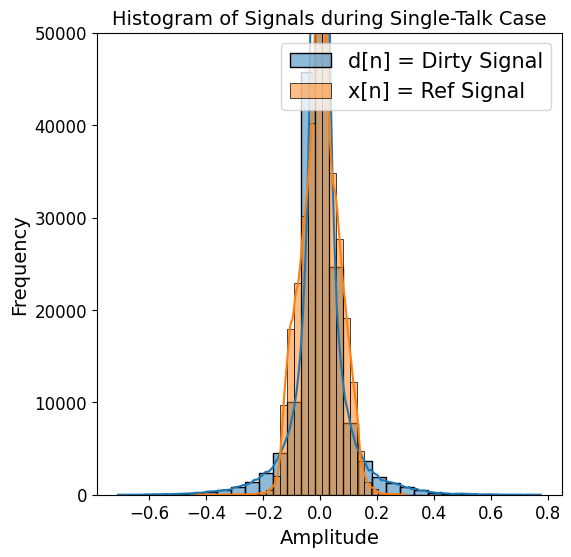

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot using Seaborn
plt.figure(figsize=(6, 6))
sns.histplot(d_1, bins=30, kde=True, label="d[n] = Dirty Signal")
sns.histplot(x_1, bins=30, kde=True, label="x[n] = Ref Signal")
plt.title('Histogram of Signals during Single-Talk Case', fontsize=14)
plt.xlabel('Amplitude', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.ylim(0, 50000) # For zooming in
# plt.yscale("log") # Doesn't look visually right
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

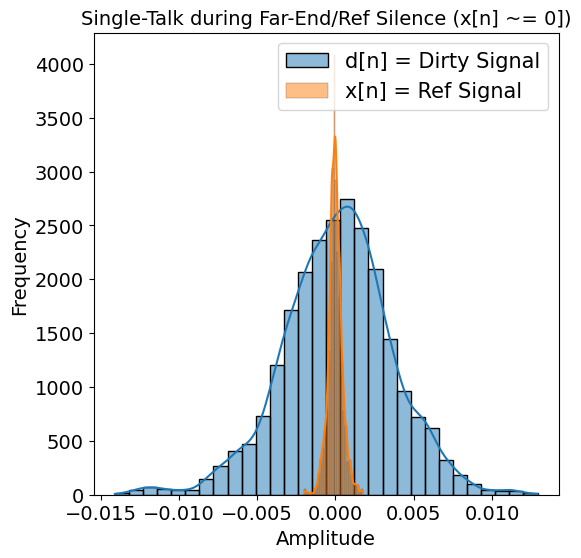

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot using Seaborn
plt.figure(figsize=(6, 6))
sns.histplot(d_1[(8*sr):int(8.5*sr)], bins=30, kde=True, label="d[n] = Dirty Signal")
sns.histplot(x_1[(8*sr):int(8.5*sr)], bins=30, kde=True, label="x[n] = Ref Signal")
plt.title('Single-Talk during Far-End/Ref Silence (x[n] ~= 0])', fontsize=14)
plt.xlabel('Amplitude', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# plt.ylim(0, 100000) # For zooming in
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=15)
plt.show()

In [ ]:
noise_pow = np.cov(d_1[(8*sr):int(8.5*sr)])
noise_pow_db = 10 * np.log10(noise_pow)
print("Environment Noise Power: ", str(noise_pow_db), " dB")

Environment Noise Power:  -49.05128767055921  dB


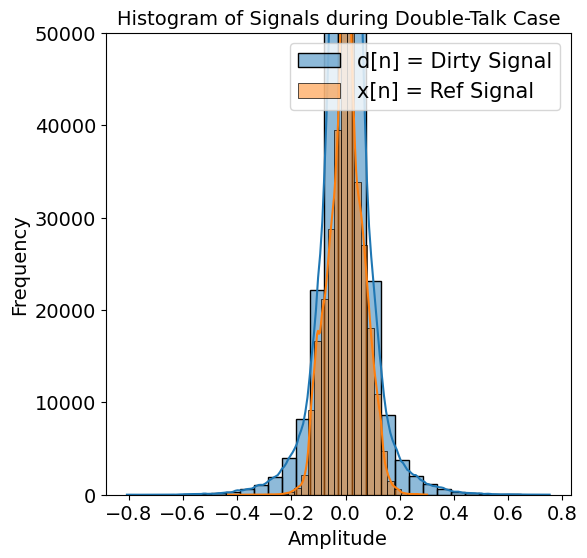

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot using Seaborn
plt.figure(figsize=(6, 6))
sns.histplot(d_2, bins=30, kde=True, label="d[n] = Dirty Signal")
sns.histplot(x_2, bins=30, kde=True, label="x[n] = Ref Signal")
plt.title('Histogram of Signals during Double-Talk Case', fontsize=14)
plt.xlabel('Amplitude', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.ylim(0, 50000) # For zooming in
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

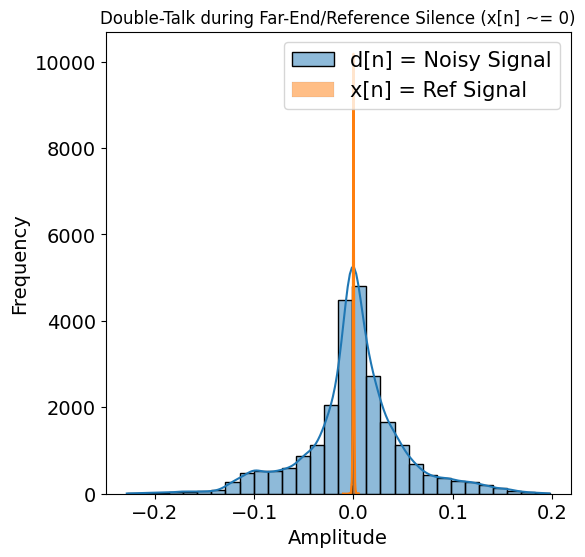

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot using Seaborn
plt.figure(figsize=(6, 6))
sns.histplot(d_2[int(5.5*sr):6*sr], bins=30, kde=True, label="d[n] = Noisy Signal")
sns.histplot(x_2[int(5.5*sr):6*sr], bins=30, kde=True, label="x[n] = Ref Signal")
plt.title('Double-Talk during Far-End/Reference Silence (x[n] ~= 0)')
plt.xlabel('Amplitude', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# plt.ylim(0, 100000) # For zooming in
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
near_end_pow = np.cov(d_2[int(5.5*sr):int(6*sr)])
near_end_db = 10 * np.log10(near_end_pow)
print("Near-End Talker Power: ", str(near_end_db), " dB")

Near-End Talker Power:  -25.789091428967343  dB


In [ ]:
import numpy as np
from scipy.linalg import toeplitz

def wiener_filter(noisy_signal, desired_signal, filter_length):
    # Compute the autocorrelation of the noisy signal
    r = np.correlate(noisy_signal, noisy_signal, mode='full')
    r = r[len(r) // 2:len(r) // 2 + filter_length]

    # Compute the cross-correlation between the noisy signal and the desired signal
    p = np.correlate(noisy_signal, desired_signal, mode='full')
    p = p[len(p) // 2:len(p) // 2 + filter_length]

    # Solve the Wiener-Hopf equations to find the filter coefficients
    R = toeplitz(r)
    h = np.linalg.solve(R, p)

    return h

h = wiener_filter(d_1, x_1, 64)
print(h)

[ 8.82374585e-01 -9.74522769e-01  2.11340174e-01  4.87881988e-01
  8.37500989e-02 -2.23365098e-01 -1.43941253e-01  1.43883200e-02
  9.04565230e-02 -2.90977955e-02  1.78723577e-02 -7.73661733e-02
  3.32200043e-02  5.36653809e-02 -2.50332393e-02 -2.40954198e-02
  1.27630070e-01  1.17045688e-02  4.76843491e-02  7.62967616e-02
  3.19589786e-02 -4.33801562e-02 -8.19050800e-03 -2.40408685e-02
 -7.30477134e-03  5.88096818e-03 -1.83213002e-03  2.01636441e-02
 -4.55477238e-02 -5.83753027e-02 -5.68928234e-02  2.68981662e-02
  8.55602324e-03  6.91077188e-02  1.08735133e-02 -2.35058647e-03
 -3.75659987e-02 -1.24274157e-02  4.50725015e-03  2.24346165e-02
  8.23431276e-03  4.47435863e-03  2.20843740e-02 -4.24553491e-02
 -2.66838837e-02 -3.87150310e-02  3.11326142e-03 -4.52394225e-03
  4.79766950e-02 -1.15969381e-03 -6.46519661e-03 -1.71933081e-02
  2.40032077e-02 -6.59967354e-03 -4.39549563e-04  1.06173037e-02
  3.63916457e-02  5.29769398e-02 -1.20689954e-04 -7.92820007e-02
 -1.13525093e-01  5.75149

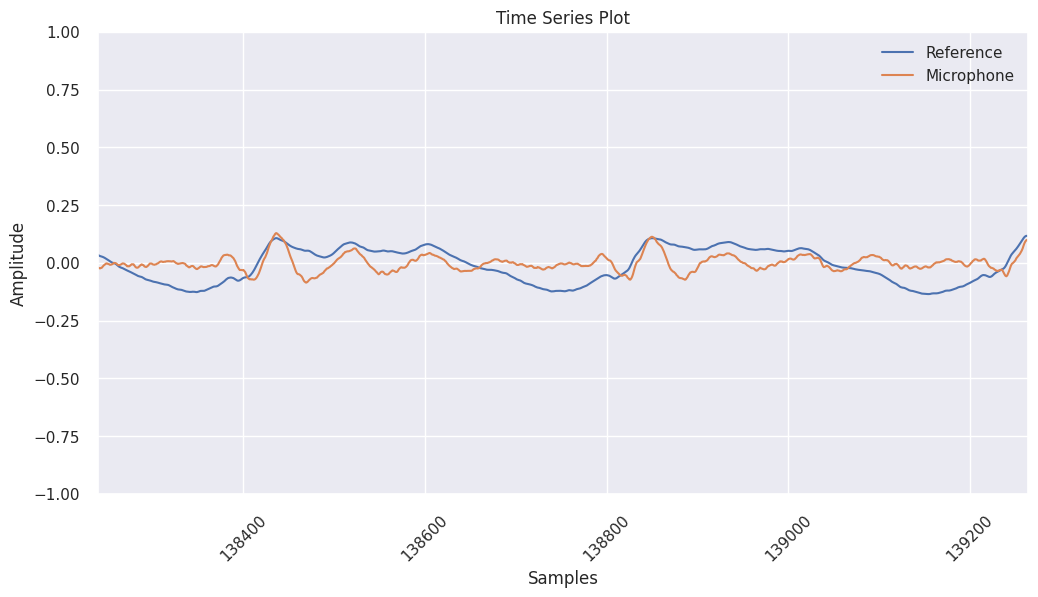

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


t = [t for t in range(len(x_1))]
# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x=t, y=x_1, label="Reference")
sns.lineplot(x=t, y=d_1, label="Microphone")
plt.xticks(rotation=45)
plt.title('Time Series Plot')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.ylim([-1, 1])
plt.xlim([(2.88*sr), (2.88 * sr + 1024)])
plt.show()

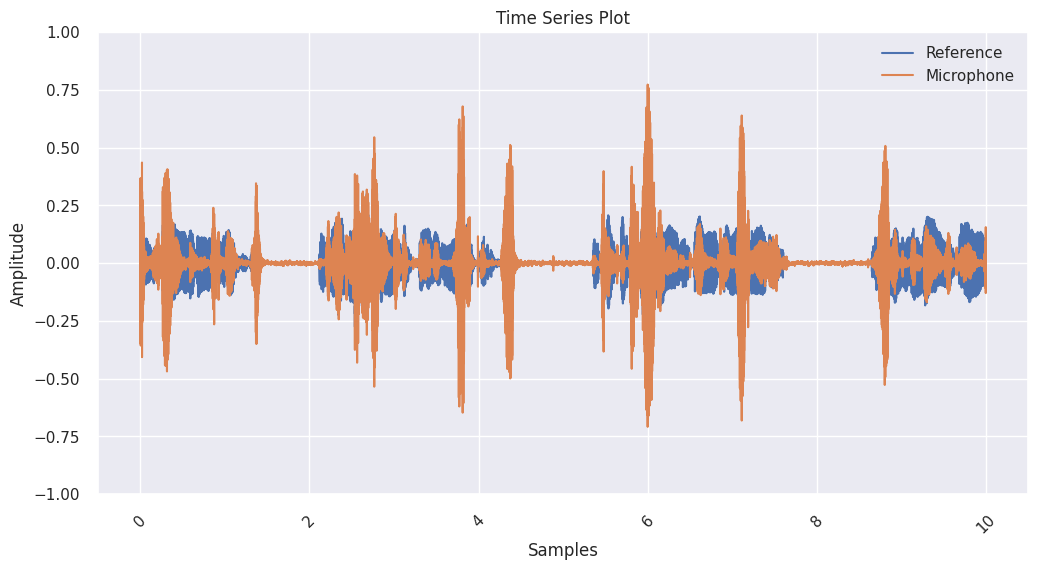

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


t = [t/sr for t in range(len(x_1))]
# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x=t, y=x_1, label="Reference")
sns.lineplot(x=t, y=d_1, label="Microphone")
plt.xticks(rotation=45)
plt.title('Time Series Plot')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.ylim([-1, 1])
plt.show()

In [ ]:
indices = np.where(f < 12000)[0]
indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127])

In [ ]:
np.sum(Cxd_db[2:127]) / (Cxd_db[2:127].shape[0]) # Roughly how much dB in Signal to cancel

12.97779296875

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


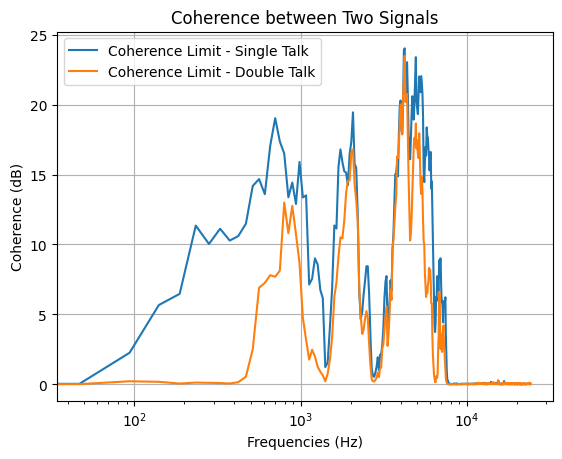

In [ ]:
"""
Get Coherence Limits
on Single-Talk Situation & Double-Talk Situation
"""
Cxd, frequencies = mscohere(x_1, d_1, sr)
Cxd_db = -10 * np.log10(1 - np.real(Cxd))
# smooth_val = 0.9999
# Cxd_db = smooth_val * Cxd_db + (1 - smooth_val) * Cxd_db
Cxd_2, frequencies = mscohere(x_2, d_2, sr)
Cxd2_db = -10 * np.log10(1 - Cxd_2)
plt.semilogx(frequencies, Cxd_db, label = "Coherence Limit - Single Talk")
plt.semilogx(frequencies, Cxd2_db, label = "Coherence Limit - Double Talk")
plt.xlabel("Frequencies (Hz)")
plt.ylabel("Coherence (dB)")
plt.title("Coherence between Two Signals")

plt.legend()
plt.grid(True)
plt.show()

In [5]:
import numpy as np
from numpy.fft import rfft as fft
from numpy.fft import irfft as ifft
import librosa
import soundfile as sf
# import pyroomacoustics as pra

""" Least Mean Squares Filter """
def lms(x, d, N = 4, mu = 0.1):
  nIters = min(len(x),len(d)) - N
  u = np.zeros(N)
  w = np.zeros(N)
  e = np.zeros(nIters)
  for n in range(nIters):
    u[1:] = u[:-1]
    u[0] = x[n]
    e_n = d[n] - np.dot(u, w)
    w = w + mu * e_n * u
    e[n] = e_n
  return e

""" Normalized Least Mean Squares Filter """
def nlms(x, d, N=4, mu=0.1):
  nIters = min(len(x),len(d)) - N
  u = np.zeros(N)
  w = np.zeros(N)
  e = np.zeros(nIters)
  for n in range(nIters):
    u[1:] = u[:-1]
    u[0] = x[n]
    e_n = d[n] - np.dot(u, w)
    w = w + mu * e_n * u / (np.dot(u,u)+1e-3)
    e[n] = e_n
  return e

""" Sign-Sign Least Mean Squares Filter """
def sign_sign_lms(x, d, N=4, mu=0.1):
    nIters = min(len(x), len(d)) - N
    u = np.zeros(N)
    w = np.zeros(N)
    e = np.zeros(nIters)
    for n in range(nIters):
        u[1:] = u[:-1]
        u[0] = x[n]
        e_n = d[n] - np.dot(u, w)
        w = w + mu * np.sign(e_n) * np.sign(u)
        e[n] = e_n
    return e

""" Kalman Filter """
def kalman(x, d, N = 64, sgm2v=1e-4):
  nIters = min(len(x),len(d)) - N
  u = np.zeros(N)
  w = np.zeros(N)
  Q = np.eye(N)*sgm2v
  P = np.eye(N)*sgm2v
  I = np.eye(N)
  e = np.zeros(nIters)
  for n in range(nIters):
    u[1:] = u[:-1]
    u[0] = x[n]
    e_n =  d[n] - np.dot(u, w)
    R = e_n**2+1e-10
    Pn = P + Q
    r = np.dot(Pn,u)
    K = r / (np.dot(u, r) + R + 1e-10)
    w = w + np.dot(K, e_n)
    P = np.dot(I - np.outer(K, u), Pn)
    e[n] = e_n

  return e

# """ Frequency Domain Kalman Filter """
# def fdkf(x, d, M, beta=0.95, sgm2u=1e-2, sgm2v=1e-6):
#   Q = sgm2u
#   R = np.full(M+1,sgm2v)
#   H = np.zeros(M+1,dtype=np.complex128)
#   P = np.full(M+1,sgm2u)

#   window =  np.hanning(M)
#   x_old = np.zeros(M)

#   num_block = min(len(x),len(d)) // M
#   e = np.zeros(num_block*M)

#   for n in range(num_block):
#     x_n = np.concatenate([x_old,x[n*M:(n+1)*M]])
#     d_n = d[n*M:(n+1)*M]
#     x_old = x[n*M:(n+1)*M]

#     X_n = np.fft.rfft(x_n)

#     y_n = ifft(H*X_n)[M:]
#     e_n = d_n-y_n

#     e_fft = np.concatenate([np.zeros(M),e_n*window])
#     E_n = fft(e_fft)

#     R = beta*R + (1.0 - beta)*(np.abs(E_n)**2)
#     P_n = P + Q*(np.abs(H) ** 2)
#     K = P_n*X_n.conj()/(X_n*P_n*X_n.conj()+R)
#     P = (1.0 - K*X_n)*P_n

#     # Overlap-and Save Constraint
#     H = H + K*E_n
#     h = ifft(H)
#     h[M:] = 0
#     H = fft(h)

#     e[n*M:(n+1)*M] = e_n

#   return e


sr = sr_x

""" Least Mean Squares Filter on Huber """
def huber_lms(x, d, N = 4, mu = 0.1, delta = 1.0):
  nIters = min(len(x),len(d)) - N
  u = np.zeros(N)
  w = np.zeros(N)
  e = np.zeros(nIters)
  for n in range(nIters):
    u[1:] = u[:-1]
    u[0] = x[n]
    e_n = d[n] - np.dot(u, w)

    if np.abs(e_n) <= delta:
        grad_w = e_n * u
    else:
        grad_w = delta * u * np.sign(e_n)
    w = w + mu * grad_w
    e[n] = e_n
  return e

""" Least Mean Squares Filter on Huber """
def huber_nlms(x, d, N = 4, mu = 0.1, delta = 1.0):
  nIters = min(len(x),len(d)) - N
  u = np.zeros(N)
  w = np.zeros(N)
  e = np.zeros(nIters)
  for n in range(nIters):
    u[1:] = u[:-1]
    u[0] = x[n]
    e_n = d[n] - np.dot(u, w)

    if np.abs(e_n) <= delta:
        grad_w = e_n * u
    else:
        grad_w = delta * u * np.sign(e_n)

    norm_grad_w = grad_w / (np.dot(grad_w, grad_w) + 1e-3)
    w = w + mu * grad_w
    e[n] = e_n
  return e




In [6]:
import numpy as np
from scipy.fft import fft, ifft

# Short Time Fourier Transform
def stft(x, window, nfft, overlap):
    step = len(window) - overlap
    shape = ((x.size - overlap) // step, len(window))
    strides = (x.strides[0] * step, x.strides[0])
    windows = np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)
    return np.fft.rfft(windows * window, n=nfft), windows.shape[0]

# Inverse Short Time Fourier Transform
def istft(X, window, nfft, overlap):
    step = len(window) - overlap
    time_signal = np.zeros((X.shape[0] - 1) * step + nfft)
    window_correction = np.zeros((X.shape[0] - 1) * step + nfft)
    for i in range(X.shape[0]):
        time_signal[i * step:i * step + nfft] += np.fft.irfft(X[i], n=nfft)
        window_correction[i * step:i * step + nfft] += window
    return time_signal / (window_correction + 1e-10)

""" Frequency Domain Kalman Filter (Fixed) """
def fdkf_stft(x, d, M, beta=0.95, sgm2u=1e-2, sgm2v=1e-6):
    Q = sgm2u
    R = np.full(M//2 + 1, sgm2v)
    H = np.zeros(M//2 + 1, dtype=np.complex128)
    P = np.full(M//2 + 1, sgm2u)

    window = np.hamming(M)
    overlap = M // 2
    nfft = M

    X_stft, num_blocks = stft(x, window, nfft, overlap)
    D_stft, _ = stft(d, window, nfft, overlap)

    e_stft = np.zeros_like(X_stft, dtype=np.complex128)

    for n in range(num_blocks):
        X_n = X_stft[n]
        D_n = D_stft[n]

        Y_n = H * X_n
        E_n = D_n - Y_n

        R = beta * R + (1.0 - beta) * (np.abs(E_n) ** 2)
        P_n = P + Q * (np.abs(H) ** 2)
        K = P_n * X_n.conj() / (X_n * P_n * X_n.conj() + R)
        P = (1.0 - K * X_n) * P_n

        H = H + K * E_n

        e_stft[n] = E_n

    e = istft(e_stft, window, nfft, overlap)
    return e


In [7]:
""" Kalman Filter Derivation on Huber Loss """
def kalman_huber(x, d, N=64, sgm2v=1e-4, delta=1.0):
    nIters = min(len(x), len(d)) - N
    u = np.zeros(N)
    w = np.zeros(N)
    Q = np.eye(N) * sgm2v
    P = np.eye(N) * sgm2v
    I = np.eye(N)
    e = np.zeros(nIters)

    for n in range(nIters):
        u[1:] = u[:-1]
        u[0] = x[n]
        e_n = d[n] - np.dot(u, w)

        # Calculate Huber loss and its gradient
        if np.abs(e_n) <= delta:
            R = 1.0  # when using Huber loss, consider the small gradient (similar to squared error part)
            grad_huber = e_n
        else:
            R = delta / np.abs(e_n)  # when using Huber loss, consider the large gradient (similar to absolute error part)
            grad_huber = delta * np.sign(e_n)

        Pn = P + Q
        r = np.dot(Pn, u)
        K = r / (np.dot(u, r) + R + 1e-10)
        w = w + np.dot(K, grad_huber)
        P = np.dot(I - np.outer(K, u), Pn)
        e[n] = e_n

    return e

In [ ]:
"""
Use the Covariance of x[n] & d[n] to find ideal learning rate on LMS
"""
cov = np.cov(d_1, x_1)
print(cov)
U, S, Vh = np.linalg.svd(cov) # To find ideal LMS Learning Rate
print(S)

[[0.00281182 0.0009132 ]
 [0.0009132  0.00293618]]
[0.00378932 0.00195868]


In [ ]:
cov = np.cov(d_2, x_2)
print(cov)
U, S, Vh = np.linalg.svd(cov) # To find ideal LMS Learning Rate
print(S)

[[0.00517984 0.00110566]
 [0.00110566 0.00284175]]
[0.00561988 0.00240171]


In [ ]:
"""
This is to find the some tuning parameters for the Kalman Filter
"""
white_noise = d_1[(8*sr):int(8.5*sr)]
print(np.cov(white_noise))
x_dummy = x_1[(8*sr):int(8.5*sr)]
variances = np.cov(white_noise, x_dummy)
print(variances)
np.linalg.svd(variances) # To have a feel of sigma2v

1.2441456714913804e-05
[[ 1.24414567e-05 -2.66531652e-08]
 [-2.66531652e-08  2.04428990e-07]]


SVDResult(U=array([[-0.99999763,  0.00217806],
       [ 0.00217806,  0.99999763]]), S=array([1.24415148e-05, 2.04370937e-07]), Vh=array([[-0.99999763,  0.00217806],
       [ 0.00217806,  0.99999763]]))

In [8]:
# Single Talk Situation
print("Now Looking into Single-Talk Situation")
print("processing time domain adaptive filters.")
""" Least Mean Squares Filter """
e_lms = lms(x_1, d_1, N=64, mu=0.1)
e_lms = np.clip(e_lms,-1,1)
sf.write('single_talk/lms.wav', e_lms, sr, subtype='PCM_16')

print("LMS - Done!")

""" Normalized Least Mean Squares Filter """
e_nlms = nlms(x_1, d_1, N=64, mu=0.999)
e_nlms = np.clip(e_nlms,-1,1)
sf.write('single_talk/nlms.wav', e_nlms, sr, subtype='PCM_16')

print("NLMS - Done!")

""" Sign-Sign Least Mean Squares Filter """
e_sslms = sign_sign_lms(x_1, d_1, N=64, mu =0.0037)
e_sslms = np.clip(e_sslms, -1, 1)
sf.write("single_talk/sslms.wav", e_sslms, sr, subtype="PCM_16")

print("Sign-Sign LMS - Done!")

""" Kalman Filter """
e_kf = kalman(x_1, d_1, N=64, sgm2v=1.25e-4)
e_kf = np.clip(e_kf,-1,1)
sf.write('single_talk/kalman.wav', e_kf, sr, subtype='PCM_16')

print("Kalman (Time-Domain) - Done!")

print("processing frequency domain adaptive filters.")

""" Frequency Domain Kalman Filter """
e_fdkf = fdkf_stft(x_1, d_1, M=128, beta=0.95, sgm2u=8e-2, sgm2v=1e-6)
e_fdkf = np.clip(e_fdkf,-1,1)
sf.write('single_talk/fdkf.wav', e_fdkf, sr, subtype='PCM_16')

print("FDKF - Done!")

""" Huber-LMS Algorithm """
e_huber_lms = huber_lms(x_1, d_1, N=64, mu=0.85, delta=0.1)
e_huber_lms = np.clip(e_huber_lms,-1,1)
sf.write('single_talk/huber_lms.wav', e_huber_lms, sr, subtype='PCM_16')

print("Huber-LMS - Done!")

""" Huber-NLMS Algorithm """
e_huber_nlms = huber_nlms(x_1, d_1, N=64, mu=0.99999, delta=0.1)
e_huber_nlms = np.clip(e_huber_nlms,-1,1)
sf.write('single_talk/huber_nlms.wav', e_huber_nlms, sr, subtype='PCM_16')

print("Huber-NLMS - Done!")

""" Huber-Kalman Algorithm """
e_kf_huber = kalman_huber(x_1, d_1, N=64, sgm2v=8e-1, delta = 0.1)
e_kf_huber = np.clip(e_kf_huber, -1, 1)
sf.write("single_talk/kf_huber.wav", e_kf_huber, sr, "PCM_32")

print("Huber-Kalman - Done!")

print("All Single-Talk Situation Done!")

Now Looking into Single-Talk Situation
processing time domain adaptive filters.
LMS - Done!
NLMS - Done!
Sign-Sign LMS - Done!
Kalman (Time-Domain) - Done!
processing frequency domain adaptive filters.
FDKF - Done!
Huber-LMS - Done!
Huber-LMS - Done!


In [ ]:
# If you have previously processed files...
# e_lms, ___ = librosa.load("./single_talk/lms.wav", sr = 48000)
# e_nlms, ___ = librosa.load("./single_talk/nlms.wav", sr = 48000)
# e_kf, ___ = librosa.load("./single_talk/kalman.wav", sr = 48000)
# e_fdkf, ___ = librosa.load("./single_talk/fdkf.wav", sr = 48000)

<ipython-input-1-42d26962cb7d>:127: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax2.set_xlim(0, f[-1])


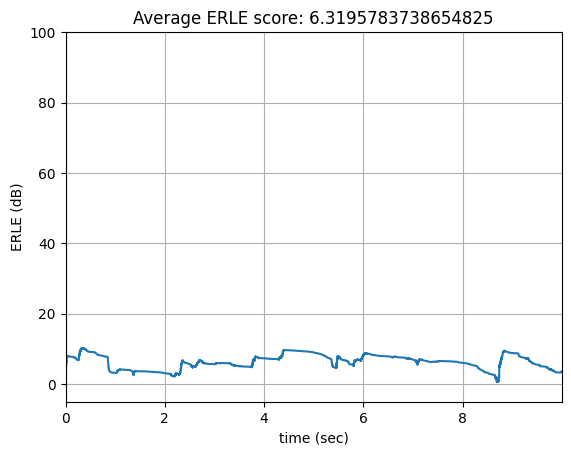

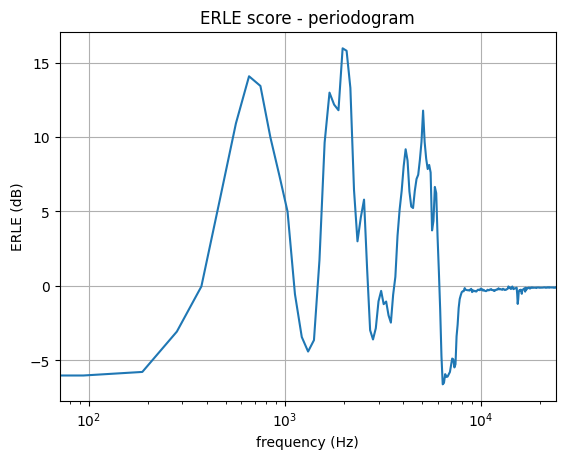

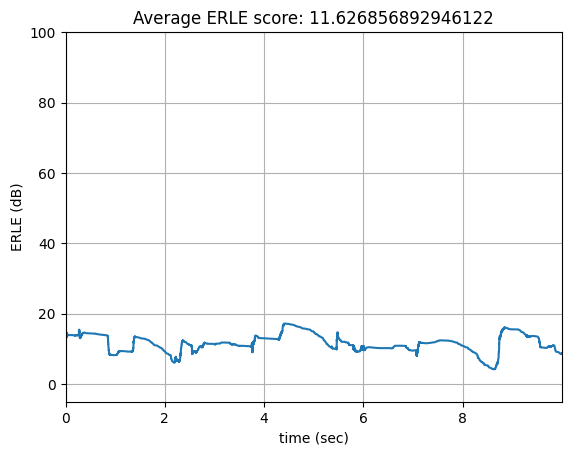

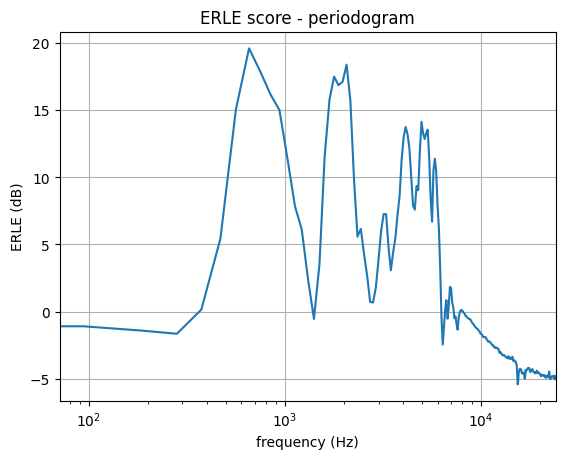

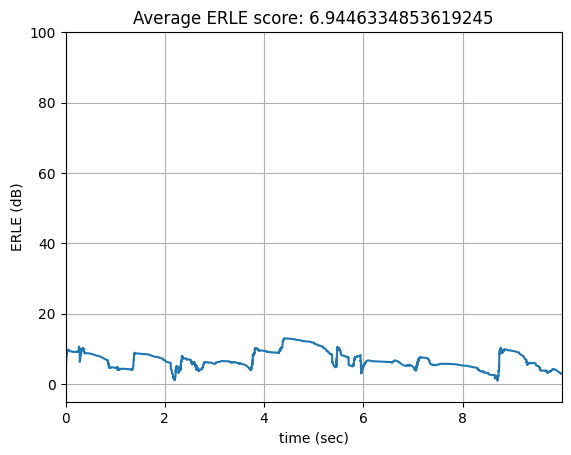

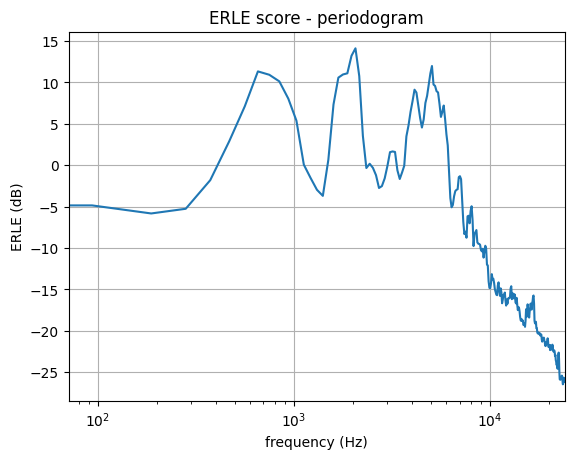

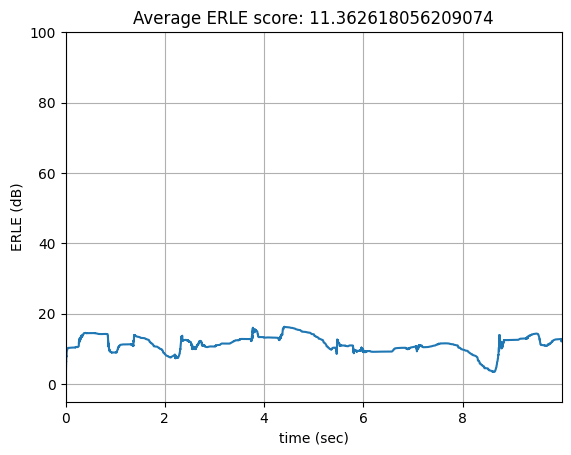

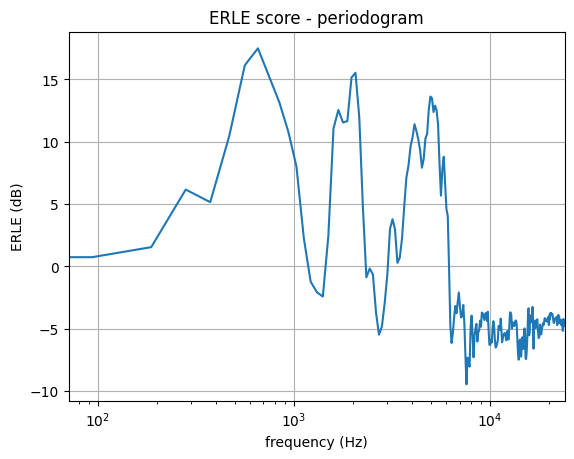

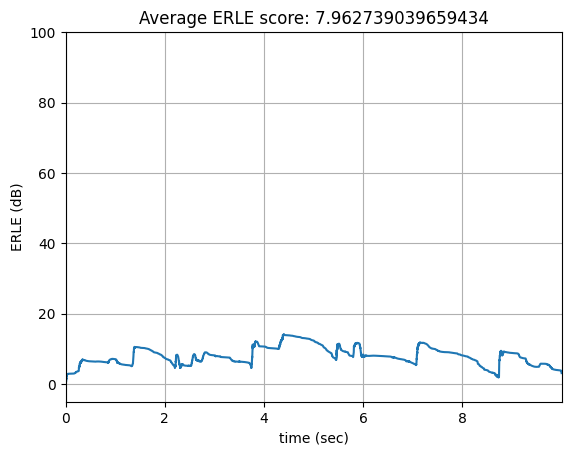

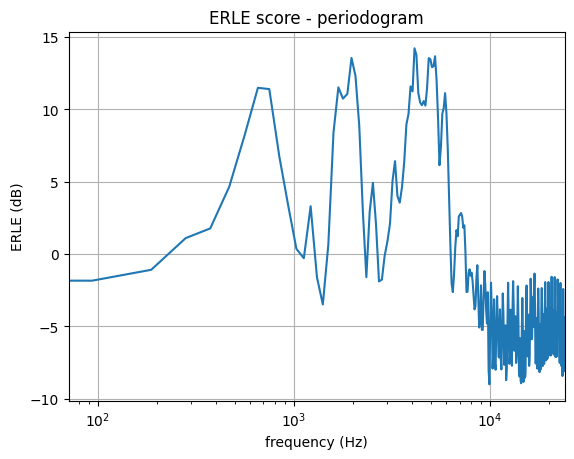

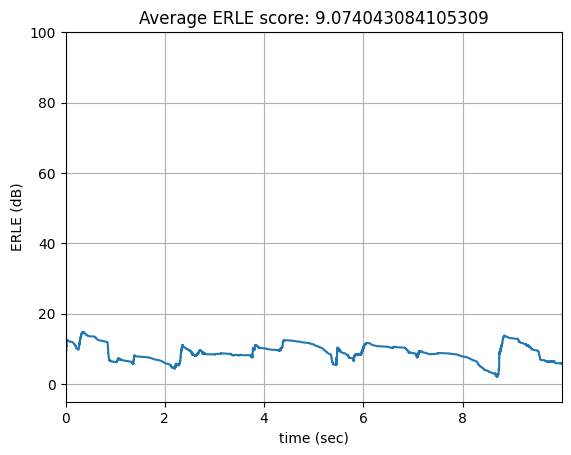

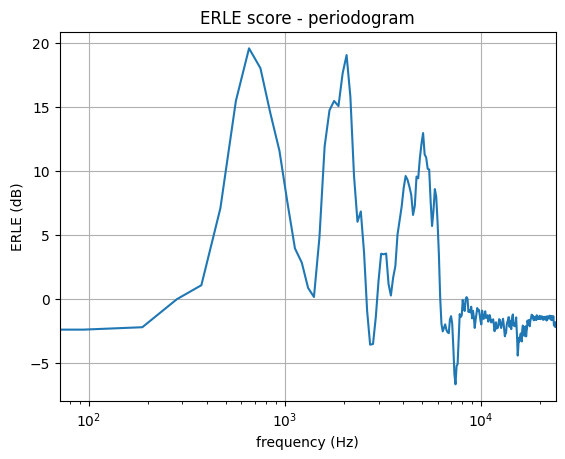

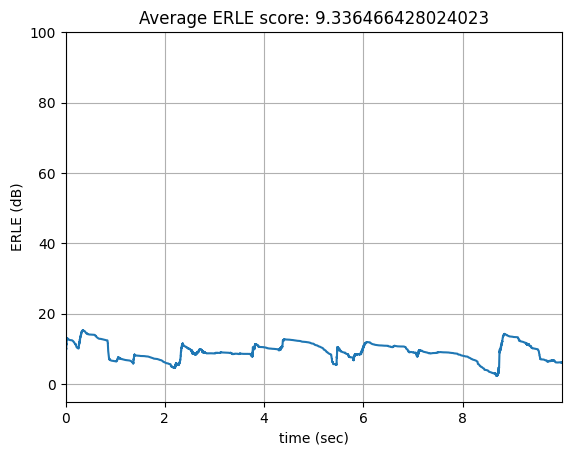

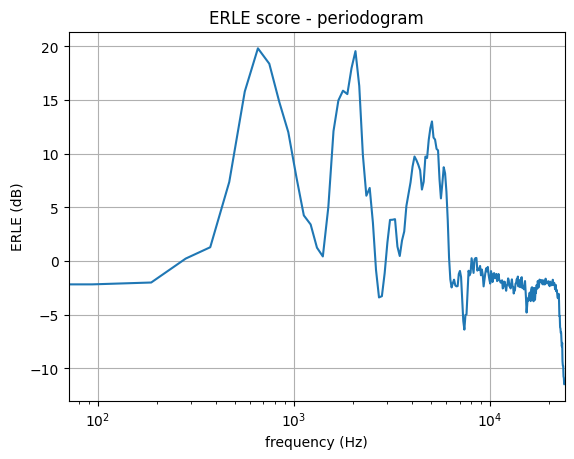

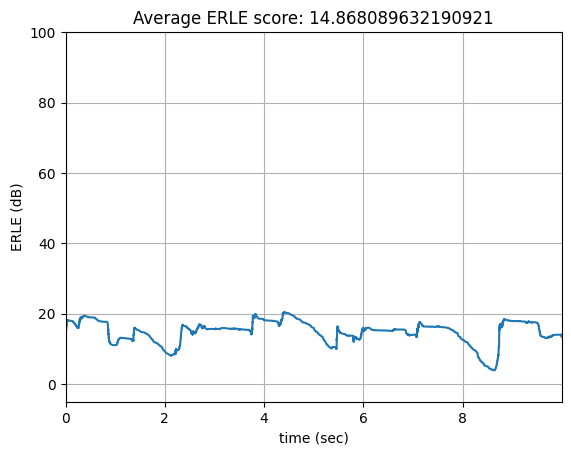

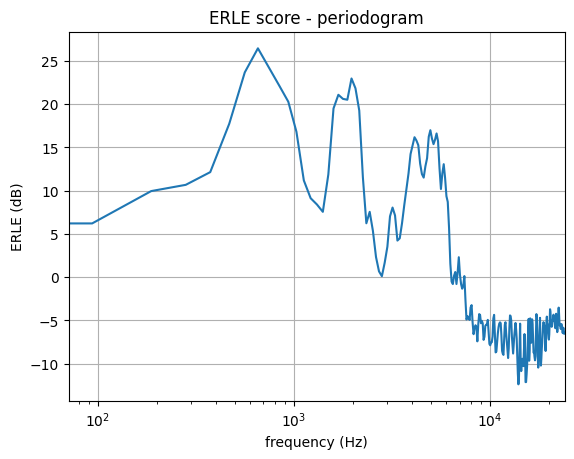

In [ ]:
"""
Calculate the Echo Return Loss Enhancement (in dB)
for single talk case
"""
erle_avg_lms, erle_lms, erle_freq_lms, f = compute_erle(d_1, e_lms, sr)
erle_avg_nlms, erle_nlms, erle_freq_nlms, f = compute_erle(d_1, e_nlms, sr)
erle_avg_sslms, erle_sslms, erle_freq_sslms, f = compute_erle(d_1, e_sslms, sr)
erle_avg_kf, erle_kf, erle_freq_kf, f = compute_erle(d_1, e_kf, sr)
erle_avg_fdkf, erle_fdkf, erle_freq_fdkf, f = compute_erle(d_1, e_fdkf, sr)
erle_avg_huber_lms, erle_huber_lms, erle_freq_huber_lms, f = compute_erle(d_1, e_huber_lms, sr_x)
erle_avg_huber_nlms, erle_huber_nlms, erle_freq_huber_nlms, f = compute_erle(d_1, e_huber_nlms, sr_x)
erle_avg_huber_kf, erle_huber_kf, erle_freq_huber_kf, f = compute_erle(d_1, e_kf_huber, sr_x)

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


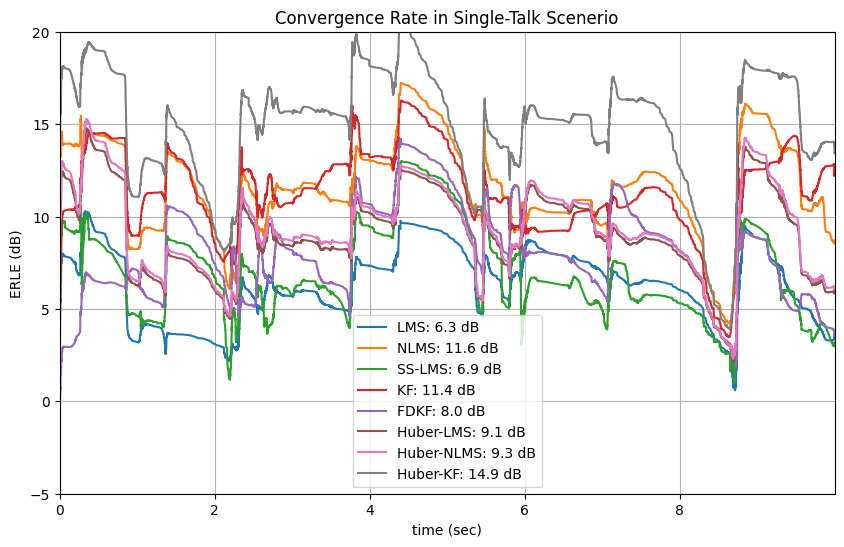

In [ ]:
"""
Plot convergence rate results in Single-Talk Situation
using the ERLE (dB) metric.
The higher the better.
Ideally want to achieve :
- infinity dB (No-noise Situation)
- 186dB (32-bit Precision Recording)
- Some dB that represents the environment noise
"""
min_len = min(d_1.shape[0], e_lms.shape[0])

fig1, ax1 = plt.subplots(figsize=(10,6))
time = np.divide(np.array(range(min_len)), sr)
ax1.plot(time, 10*np.log10(erle_lms+1e-20), label = "LMS: " + str(round(erle_avg_lms, 1)) + " dB")
ax1.plot(time, 10*np.log10(erle_nlms+1e-20), label = "NLMS: " + str(round(erle_avg_nlms, 1)) + " dB")
ax1.plot(time, 10*np.log10(erle_sslms+1e-20), label = "SS-LMS: " + str(round(erle_avg_sslms, 1)) + " dB")
ax1.plot(time, 10*np.log10(erle_kf+1e-20), label = "KF: " + str(round(erle_avg_kf, 1)) + " dB")

min_len2 = min(d_1.shape[0], e_fdkf.shape[0])
time2 = np.divide(np.array(range(min_len2)), sr)
ax1.plot(time2, 10*np.log10(erle_fdkf+1e-20), label = "FDKF: " + str(round(erle_avg_fdkf, 1)) + " dB")

ax1.plot(time, 10*np.log10(erle_huber_lms+1e-20), label = "Huber-LMS: " + str(round(erle_avg_huber_lms, 1)) + " dB")
ax1.plot(time, 10*np.log10(erle_huber_nlms+1e-20), label = "Huber-NLMS: " + str(round(erle_avg_huber_nlms, 1)) + " dB")
ax1.plot(time, 10*np.log10(erle_huber_kf+1e-20), label = "Huber-KF: " + str(round(erle_avg_huber_kf, 1)) + " dB")

ax1.set_xlabel('time (sec)')
ax1.set_ylabel('ERLE (dB)')
ax1.grid(1)
ax1.set_xlim(0, time[-1])
ax1.set_ylim(-5, 20)
ax1.set_title("Convergence Rate in Single-Talk Scenerio")
plt.legend()

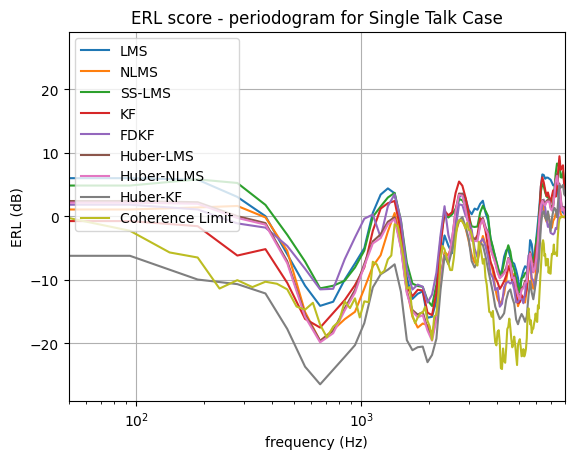

In [ ]:
fig2, ax2 = plt.subplots()
ax2.semilogx(f, -1 * erle_freq_lms, label = "LMS")
ax2.semilogx(f, -1 * erle_freq_nlms, label = "NLMS")
ax2.semilogx(f, -1 * erle_freq_sslms, label = "SS-LMS")
ax2.semilogx(f, -1 * erle_freq_kf, label = "KF")
ax2.semilogx(f, -1 * erle_freq_fdkf, label = "FDKF")
ax2.semilogx(f, -1 * erle_freq_huber_lms, label = "Huber-LMS")
ax2.semilogx(f, -1 * erle_freq_huber_nlms, label = "Huber-NLMS")
ax2.semilogx(f, -1 * erle_freq_huber_kf, label = "Huber-KF")
ax2.semilogx(frequencies, -1 * Cxd_db, label = "Coherence Limit")
ax2.set_title('ERL score - periodogram for Single Talk Case')
ax2.set_xlabel('frequency (Hz)')
ax2.set_ylabel('ERL (dB)')
ax2.grid(1)
ax2.set_xlim(50, 8000)

plt.legend()

In [9]:
# Double Talk Situation
print("Now Looking into Double-Talk Situation")
print("processing time domain adaptive filters.")
""" Least Mean Squares Filter """
e_lms = lms(x_2, d_2, N=64, mu=0.1)
e_lms = np.clip(e_lms,-1,1)
sf.write('double_talk/lms.wav', e_lms, sr, subtype='PCM_16')

print("LMS - Done!")

""" Normalized Least Mean Squares Filter """
e_nlms = nlms(x_2, d_2, N=64, mu=0.999)
e_nlms = np.clip(e_nlms,-1,1)
sf.write('double_talk/nlms.wav', e_nlms, sr, subtype='PCM_16')

print("NLMS - Done!")

""" Sign-Sign Least Mean Squares Filter """
e_sslms = sign_sign_lms(x_2, d_2, N=64, mu =0.0037)
e_sslms = np.clip(e_sslms, -1, 1)
sf.write("double_talk/sslms.wav", e_sslms, sr, subtype="PCM_16")

print("Sign-Sign LMS - Done!")

""" Kalman Filter """
e_kf = kalman(x_2, d_2, N=64, sgm2v=1.25e-4)
e_kf = np.clip(e_kf,-1,1)
sf.write('double_talk/kalman.wav', e_kf, sr, subtype='PCM_16')

print("Kalman (Time-Domain) - Done!")

print("processing frequency domain adaptive filters.")

""" Frequency Domain Kalman Filter """
e_fdkf = fdkf_stft(x_2, d_2, M=128, beta=0.95, sgm2u=8e-2, sgm2v=1e-6)
e_fdkf = np.clip(e_fdkf,-1,1)
sf.write('double_talk/fdkf.wav', e_fdkf, sr, subtype='PCM_16')

print("FDKF - Done!")

""" Huber-LMS Algorithm """
e_huber_lms = huber_lms(x_2, d_2, N=64, mu=0.85, delta=0.1)
e_huber_lms = np.clip(e_huber_lms,-1,1)
sf.write('double_talk/huber_lms.wav', e_huber_lms, sr, subtype='PCM_16')

print("Huber-LMS - Done!")

""" Huber-NLMS Algorithm """
e_huber_nlms = huber_nlms(x_2, d_2, N=64, mu=0.99999, delta=0.1)
e_huber_nlms = np.clip(e_huber_nlms,-1,1)
sf.write('double_talk/huber_nlms.wav', e_huber_nlms, sr, subtype='PCM_16')

print("Huber-LMS - Done!")

""" Huber-Kalman Algorithm """
e_kf_huber = kalman_huber(x_2, d_2, N=64, sgm2v=8e-1, delta = 0.1)
e_kf_huber = np.clip(e_kf_huber, -1, 1)
sf.write("double_talk/kf_huber.wav", e_kf_huber, sr, "PCM_16")

print("Huber-Kalman - Done!")

print("All Double-Talk Situation Done!")

Now Looking into Double-Talk Situation
processing time domain adaptive filters.
LMS - Done!
NLMS - Done!
Sign-Sign LMS - Done!
Kalman (Time-Domain) - Done!
processing frequency domain adaptive filters.
FDKF - Done!
Huber-LMS - Done!
Huber-LMS - Done!
Huber-Kalman - Done!
All Double-Talk Situation Done!


<ipython-input-1-42d26962cb7d>:127: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax2.set_xlim(0, f[-1])


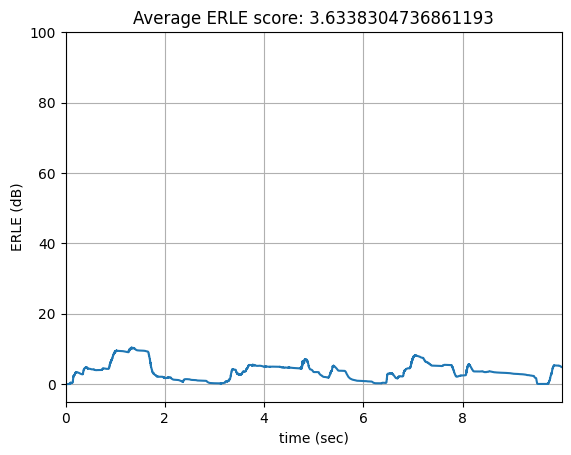

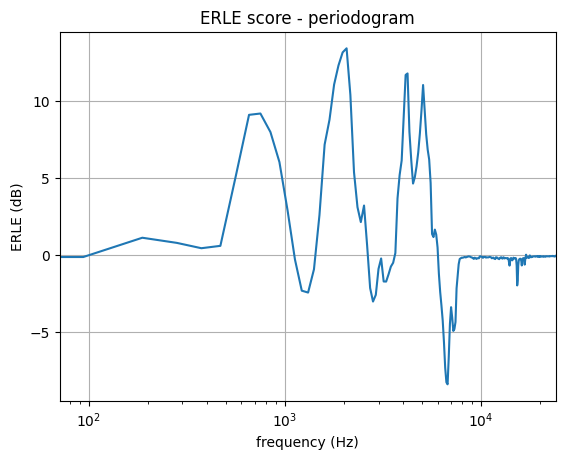

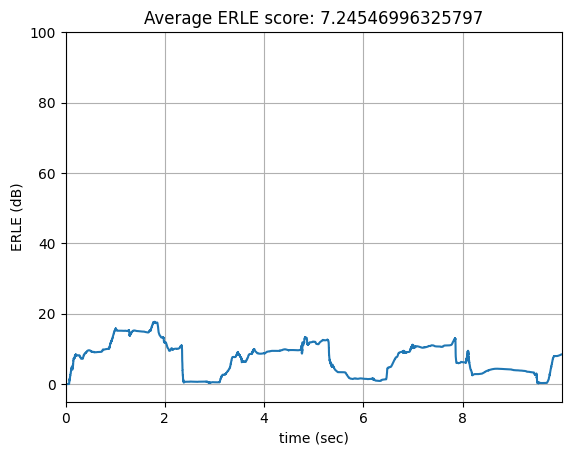

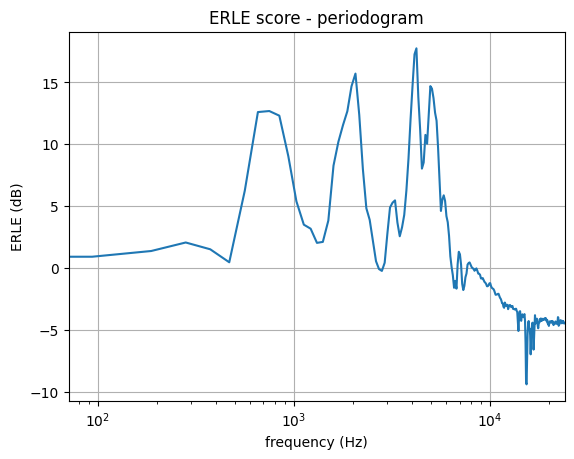

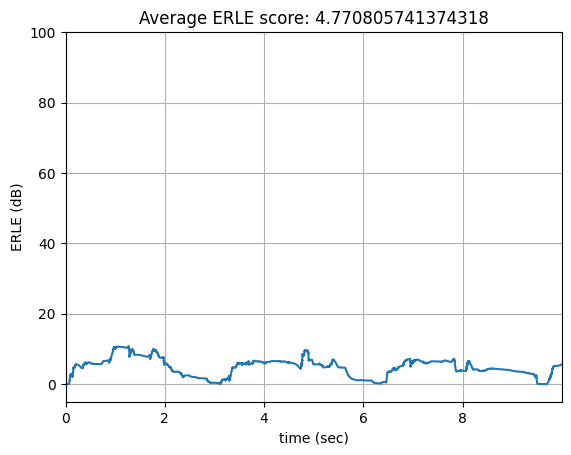

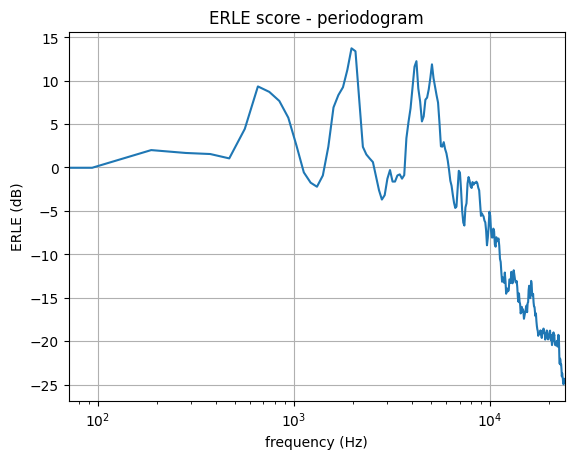

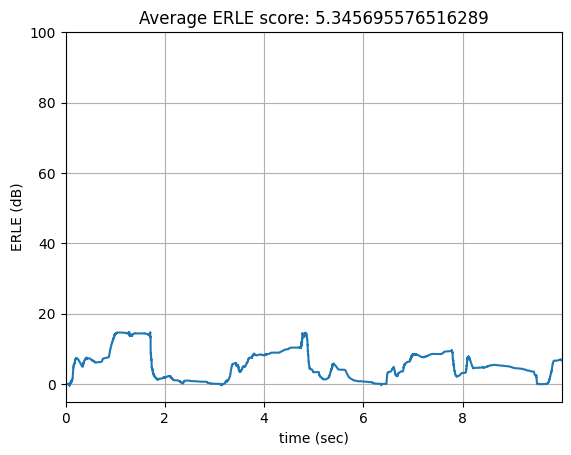

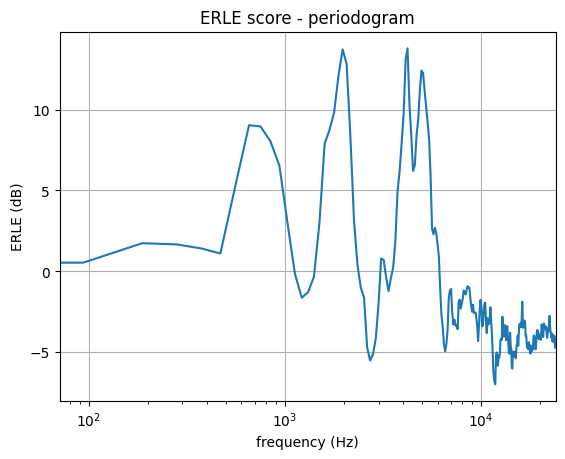

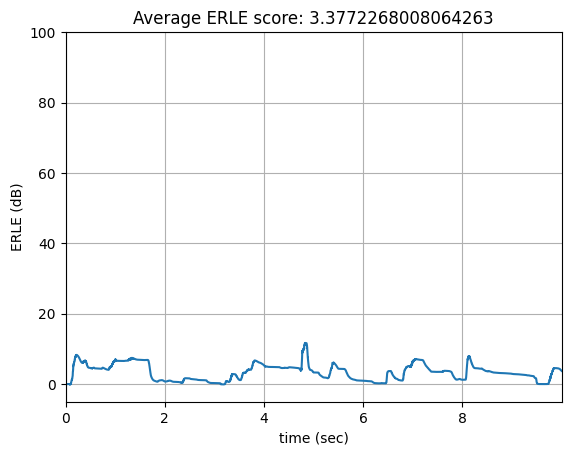

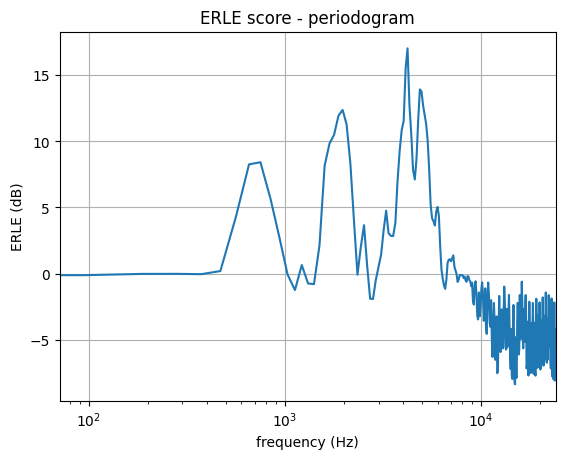

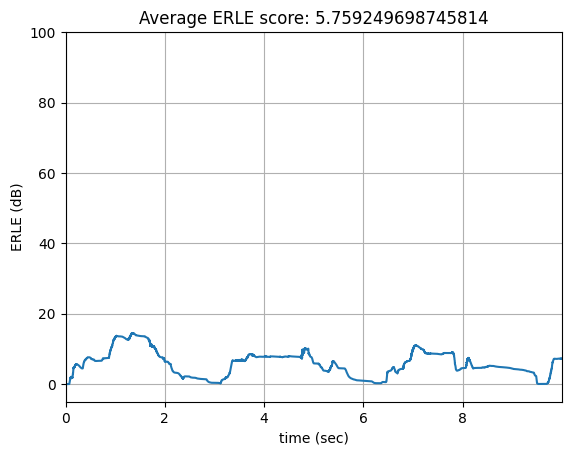

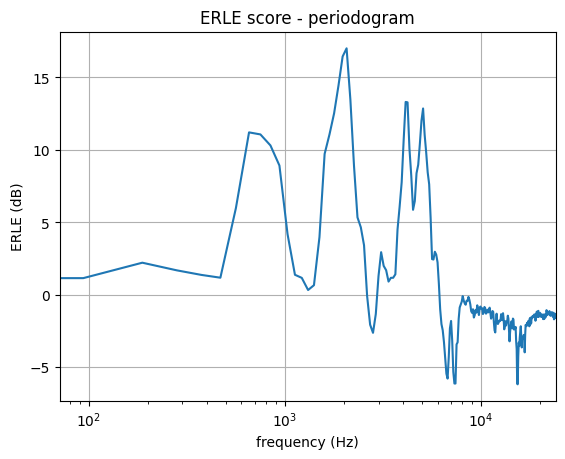

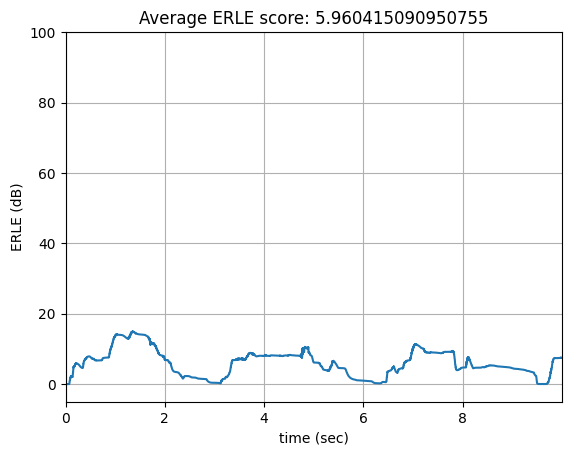

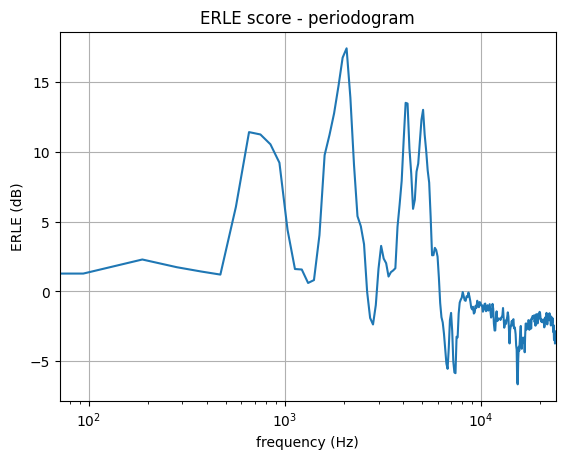

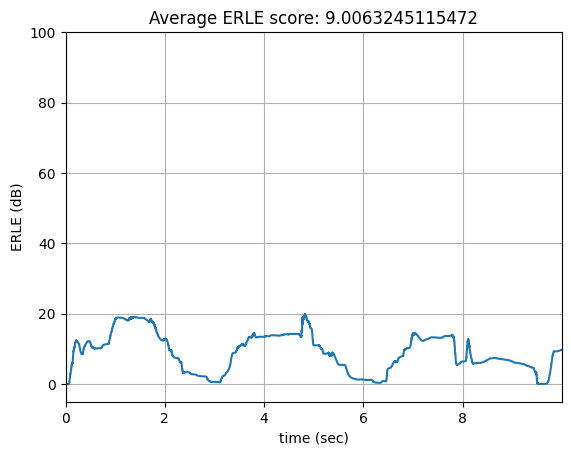

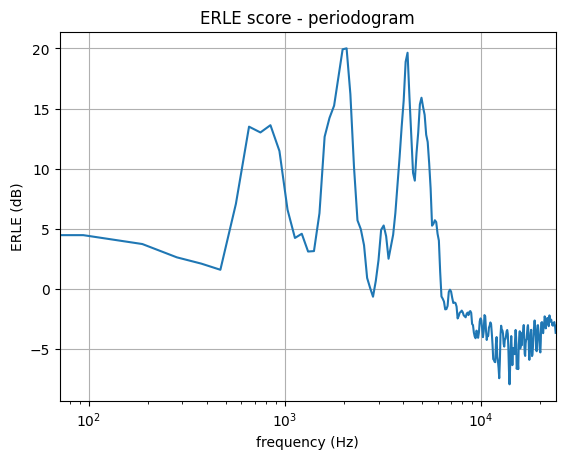

In [11]:
erle_avg_lms, erle_lms, erle_freq_lms, f = compute_erle(d_2, e_lms, sr)
erle_avg_nlms, erle_nlms, erle_freq_nlms, f = compute_erle(d_2, e_nlms, sr)
erle_avg_sslms, erle_sslms, erle_freq_sslms, f = compute_erle(d_2, e_sslms, sr)
erle_avg_kf, erle_kf, erle_freq_kf, f = compute_erle(d_2, e_kf, sr)
erle_avg_fdkf, erle_fdkf, erle_freq_fdkf, f = compute_erle(d_2, e_fdkf, sr)
erle_avg_huber_lms, erle_huber_lms, erle_freq_huber_lms, f = compute_erle(d_2, e_huber_lms, sr)
erle_avg_huber_nlms, erle_huber_nlms, erle_freq_huber_nlms, f = compute_erle(d_2, e_huber_nlms, sr)
erle_avg_huber_kf, erle_huber_kf, erle_freq_huber_kf, f = compute_erle(d_2, e_kf_huber, sr)

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


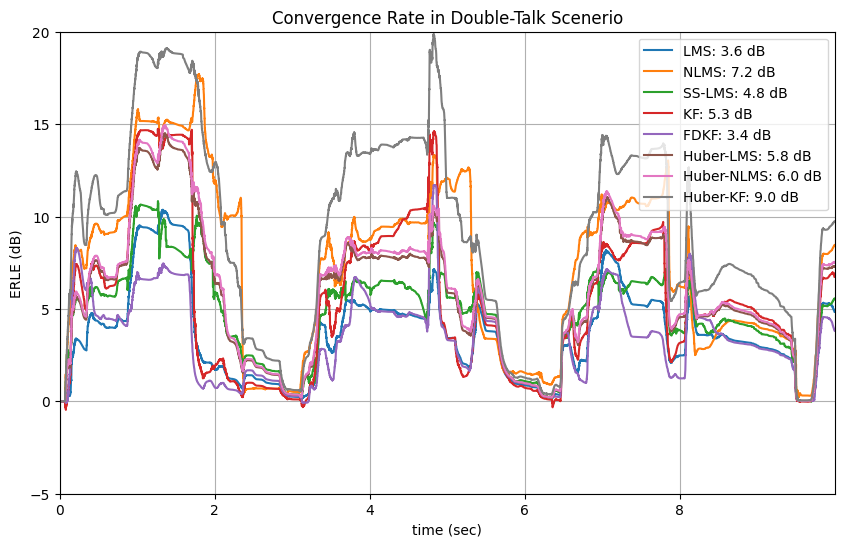

In [12]:
min_len = min(d_2.shape[0], e_lms.shape[0])

fig3, ax3 = plt.subplots(figsize=(10, 6))
time = np.divide(np.array(range(min_len)), sr)
ax3.plot(time, 10*np.log10(erle_lms+1e-20), label = "LMS: " + str(round(erle_avg_lms, 1)) + " dB")
ax3.plot(time, 10*np.log10(erle_nlms+1e-20), label = "NLMS: " + str(round(erle_avg_nlms, 1)) + " dB")
ax3.plot(time, 10*np.log10(erle_sslms+1e-20), label = "SS-LMS: " + str(round(erle_avg_sslms, 1)) + " dB")
ax3.plot(time, 10*np.log10(erle_kf+1e-20), label = "KF: " + str(round(erle_avg_kf, 1)) + " dB")

min_len2 = min(d_2.shape[0], e_fdkf.shape[0])
time2 = np.divide(np.array(range(min_len2)), sr)
ax3.plot(time2, 10*np.log10(erle_fdkf+1e-20), label = "FDKF: " + str(round(erle_avg_fdkf, 1)) + " dB")

ax3.plot(time, 10*np.log10(erle_huber_lms+1e-20), label = "Huber-LMS: " + str(round(erle_avg_huber_lms, 1)) + " dB")
ax3.plot(time, 10*np.log10(erle_huber_nlms+1e-20), label = "Huber-NLMS: " + str(round(erle_avg_huber_nlms, 1)) + " dB")
ax3.plot(time, 10*np.log10(erle_huber_kf+1e-20), label = "Huber-KF: " + str(round(erle_avg_huber_kf, 1)) + " dB")

ax3.set_xlabel('time (sec)')
ax3.set_ylabel('ERLE (dB)')
ax3.grid(1)
ax3.set_xlim(0, time[-1])
ax3.set_ylim(-5, 20)
ax3.set_title("Convergence Rate in Double-Talk Scenerio")
plt.legend()

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


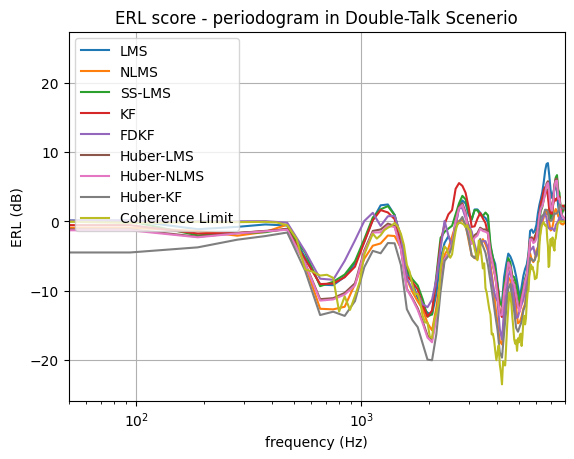

In [ ]:
fig4, ax4 = plt.subplots()
ax4.semilogx(f, -1 * erle_freq_lms, label = "LMS")
ax4.semilogx(f, -1 * erle_freq_nlms, label = "NLMS")
ax4.semilogx(f, -1 * erle_freq_sslms, label = "SS-LMS")
ax4.semilogx(f, -1 * erle_freq_kf, label = "KF")
ax4.semilogx(f, -1 * erle_freq_fdkf, label = "FDKF")
ax4.semilogx(f, -1 * erle_freq_huber_lms, label = "Huber-LMS")
ax4.semilogx(f, -1 * erle_freq_huber_nlms, label = "Huber-NLMS")
ax4.semilogx(f, -1 * erle_freq_huber_kf, label = "Huber-KF")
ax4.semilogx(frequencies, -1 * Cxd2_db, label = "Coherence Limit")
ax4.set_title('ERL score - periodogram in Double-Talk Scenerio')
ax4.set_xlabel('frequency (Hz)')
ax4.set_ylabel('ERL (dB)')
ax4.grid(1)
ax4.set_xlim(50, 8000)
plt.legend()

<ipython-input-2-42d26962cb7d>:127: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax2.set_xlim(0, f[-1])


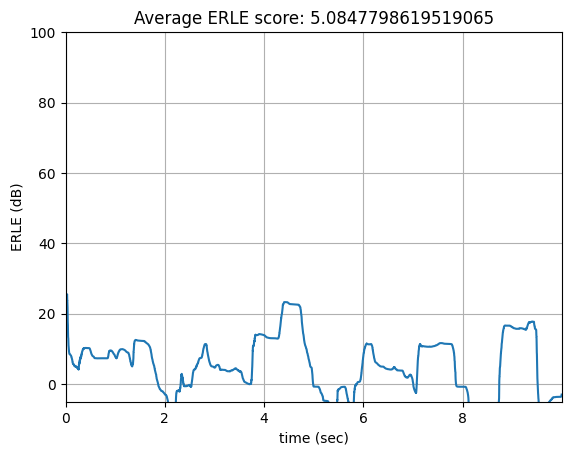

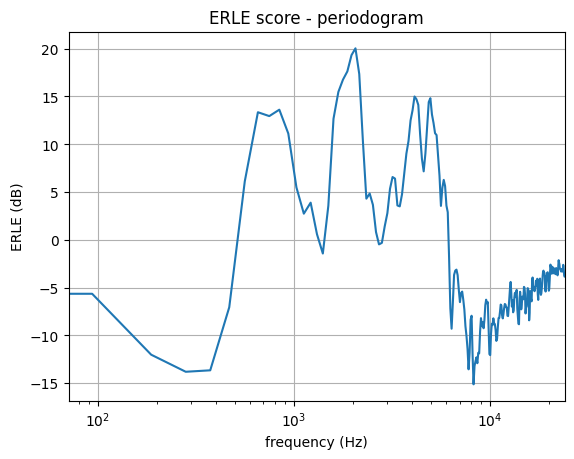

In [ ]:
erle_avg_kf_huber, erle_huber_kf_huber, erle_freq_kf_huber, f = compute_erle(d_1, e_kf_huber, sr_x)

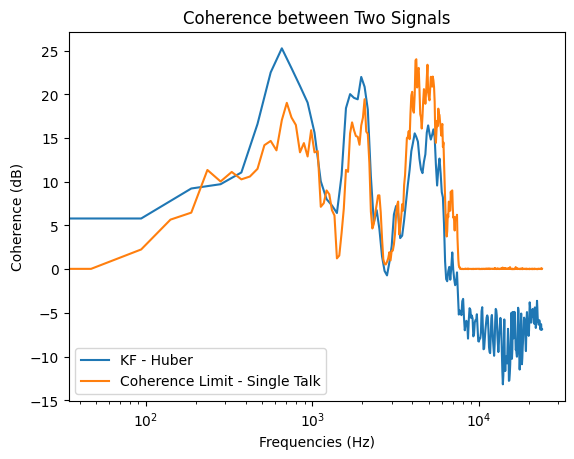

In [ ]:
plt.semilogx(f,erle_freq_kf_huber, label = "KF - Huber")
plt.semilogx(frequencies, Cxd_db, label = "Coherence Limit - Single Talk")
# plt.semilogx(frequencies, Cxd2_db, label = "Coherence Limit - Double Talk")
plt.xlabel("Frequencies (Hz)")
plt.ylabel("Coherence (dB)")
plt.title("Coherence between Two Signals")
plt.legend()

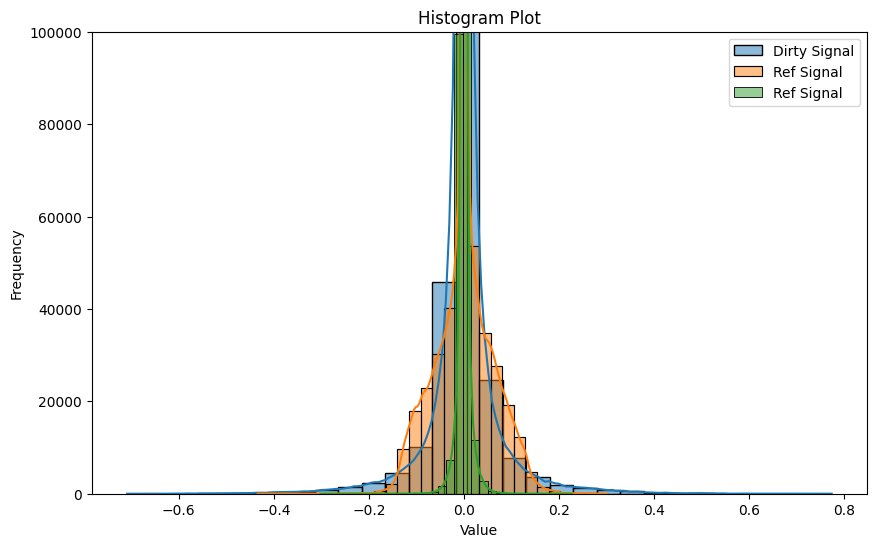

In [ ]:
# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(d_1, bins=30, kde=True, label="Dirty Signal")
sns.histplot(x_1, bins=30, kde=True, label="Ref Signal")
sns.histplot(e_kf_huber, bins=30, kde=True, label="Error Signal")
plt.title('Histogram Plot')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.ylim(0, 100000) # For zooming in
plt.legend()
plt.show()

In [ ]:
e_kf_huber = kalman_huber(x_2, d_2, N=64, sgm2v=1, delta = 0.1)

In [ ]:
sf.write("double_talk/kf_huber.wav", e_kf_huber, sr, "PCM_16")

<ipython-input-2-42d26962cb7d>:127: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax2.set_xlim(0, f[-1])


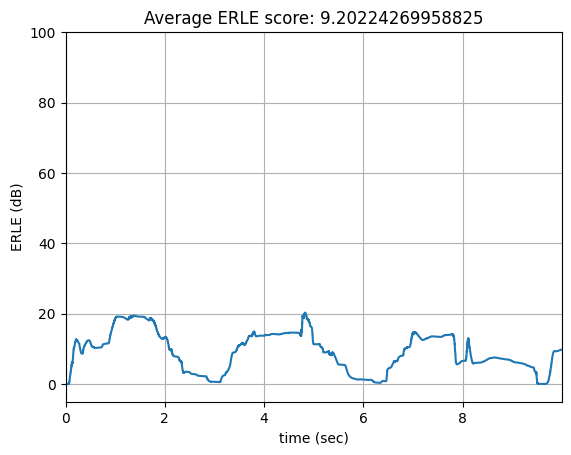

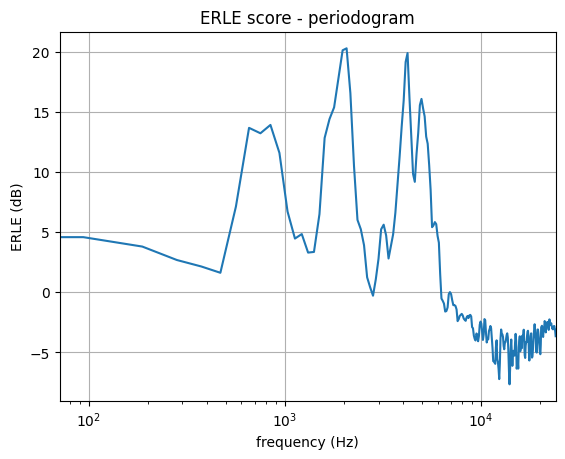

In [ ]:
erle_avg_kf_huber, erle_huber_kf_huber, erle_freq_kf_huber, f = compute_erle(d_2, e_kf_huber, sr_x)

In [ ]:
""" Frequency Domain Kalman Filter with Huber Loss """

import numpy as np
from scipy.fft import fft, ifft

def stft(x, window, nfft, overlap):
    step = len(window) - overlap
    shape = ((x.size - overlap) // step, len(window))
    strides = (x.strides[0] * step, x.strides[0])
    windows = np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)
    return np.fft.rfft(windows * window, n=nfft), windows.shape[0]

def istft(X, window, nfft, overlap):
    step = len(window) - overlap
    time_signal = np.zeros((X.shape[0] - 1) * step + nfft)
    window_correction = np.zeros((X.shape[0] - 1) * step + nfft)
    for i in range(X.shape[0]):
        time_signal[i * step:i * step + nfft] += np.fft.irfft(X[i], n=nfft)
        window_correction[i * step:i * step + nfft] += window
    return time_signal / (window_correction + 1e-10)

def huber_loss_magnitude(magnitude, delta=1.0):
    return np.where(np.abs(magnitude) <= delta, magnitude, delta * np.sign(magnitude))

def robust_kalman_update(E_n, H, X_n, P, Q, R, alpha=0.9, beta=0.95, kappa_0=1.0):
    # Compute the error magnitude
    magnitude_E_n = np.abs(E_n)
    phase_E_n = np.angle(E_n)

    # Compute Xi(e_k,l)
    Xi_E_n = np.minimum(magnitude_E_n / kappa_0, kappa_0)

    # Compute R_k,l with super-Gaussian distribution
    R_k_l = (magnitude_E_n - Xi_E_n) * np.exp(1j * phase_E_n)

    # Update R using the robust error term
    R = beta * R + (1.0 - beta) * (np.abs(R_k_l) ** 2)

    # Estimate the scale factor iota_k,l
    iota_k_l = alpha * kappa_0 + (1 - alpha) / beta * np.mean(Xi_E_n)

    # Update P and compute the Kalman gain
    P_n = P + Q * (np.abs(H) ** 2)
    K = P_n * X_n.conj() / (X_n * P_n * X_n.conj() + R)
    P = (1.0 - K * X_n) * P_n

    # Update the filter coefficients H
    H = H + K * E_n

    return H, P, R

def fdkf_stft(x, d, M, beta=0.95, sgm2u=1e-2, sgm2v=1e-6, huber_delta=1.0, alpha=0.9, kappa_0=1.0):
    Q = sgm2u
    R = np.full(M//2 + 1, sgm2v)
    H = np.zeros(M//2 + 1, dtype=np.complex128)
    P = np.full(M//2 + 1, sgm2u)

    window = np.hamming(M)
    overlap = M // 2
    nfft = M

    X_stft, num_blocks = stft(x, window, nfft, overlap)
    D_stft, _ = stft(d, window, nfft, overlap)

    e_stft = np.zeros_like(X_stft, dtype=np.complex128)

    for n in range(num_blocks):
        X_n = X_stft[n]
        D_n = D_stft[n]

        Y_n = H * X_n
        E_n = D_n - Y_n

        # Update filter coefficients using the robust Kalman update
        H, P, R = robust_kalman_update(E_n, H, X_n, P, Q, R, alpha, beta, kappa_0)

        e_stft[n] = E_n

    e = istft(e_stft, window, nfft, overlap)
    return e

# Example usage:
# x = np.random.randn(1024)  # Input signal
# d = np.random.randn(1024)  # Desired signal
# M = 256  # Frame length


# print(e)

In [ ]:
X_stft, num_blocks = stft(d_1, np.hamming(128), 128, 64)
X_stft.shape

(7499, 65)

In [ ]:
48000/128 * 20

7500.0

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


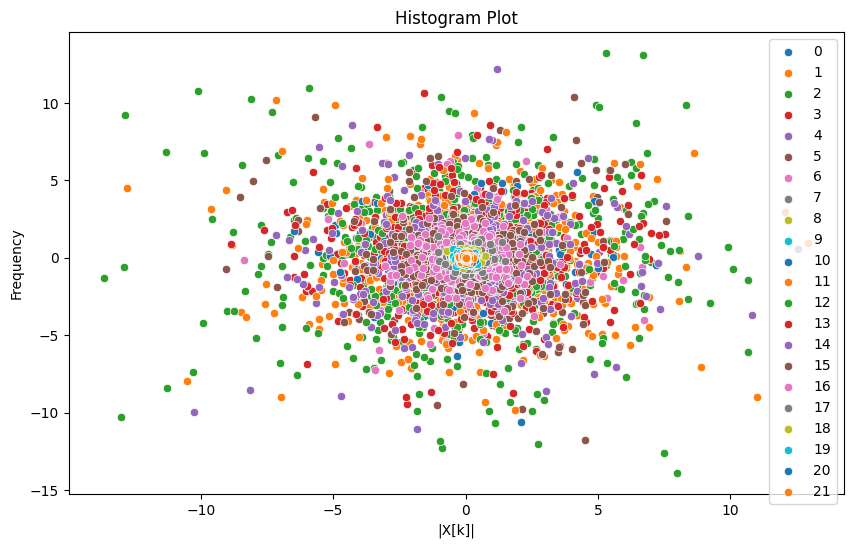

In [ ]:
# Plot using Seaborn
plt.figure(figsize=(10, 6))
for freq_idx, X_k in enumerate(np.transpose(X_stft)) :
    # sns.histplot(np.abs(X_k), bins=30, kde=True, label=str(freq_idx))
    sns.scatterplot(x= np.real(X_k), y = np.imag(X_k), label=str(freq_idx))

    if freq_idx > 20 :
        break

plt.title('Histogram Plot')
plt.xlabel('|X[k]|')
plt.ylabel('Frequency')
# plt.ylim(0, 100000) # For zooming in
plt.legend()
plt.show()

In [ ]:
e_huber_fdkf = fdkf_stft(x_1, d_1, M=128, beta=0.95, sgm2u=1e-1, sgm2v=1e-4,
                         alpha=0.75, kappa_0 = 0.1)

<ipython-input-1-42d26962cb7d>:127: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax2.set_xlim(0, f[-1])


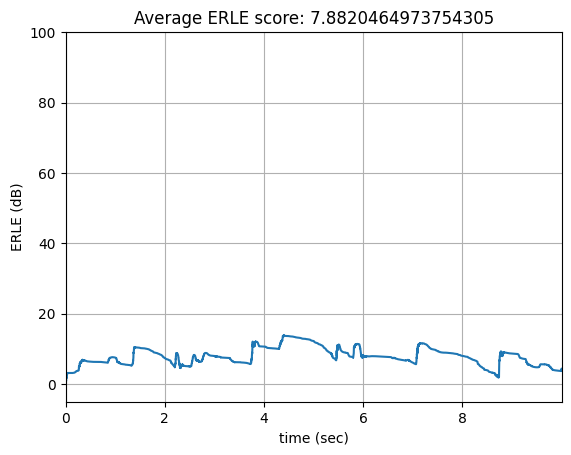

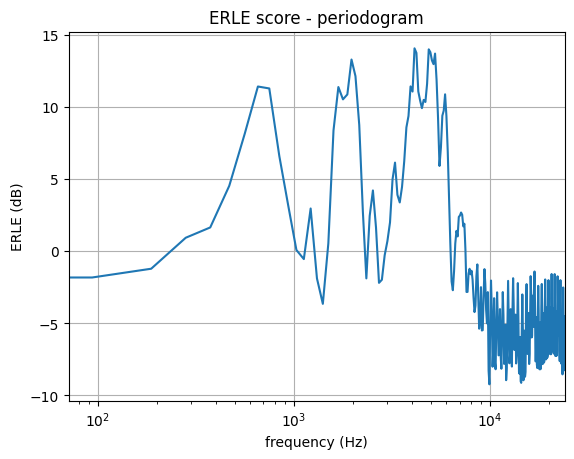

In [ ]:
erle_avg_huber_fdkf, erle_huber_fdkf, erle_freq_huber_fdkf, f = compute_erle(d_1, e_huber_fdkf, sr_x)

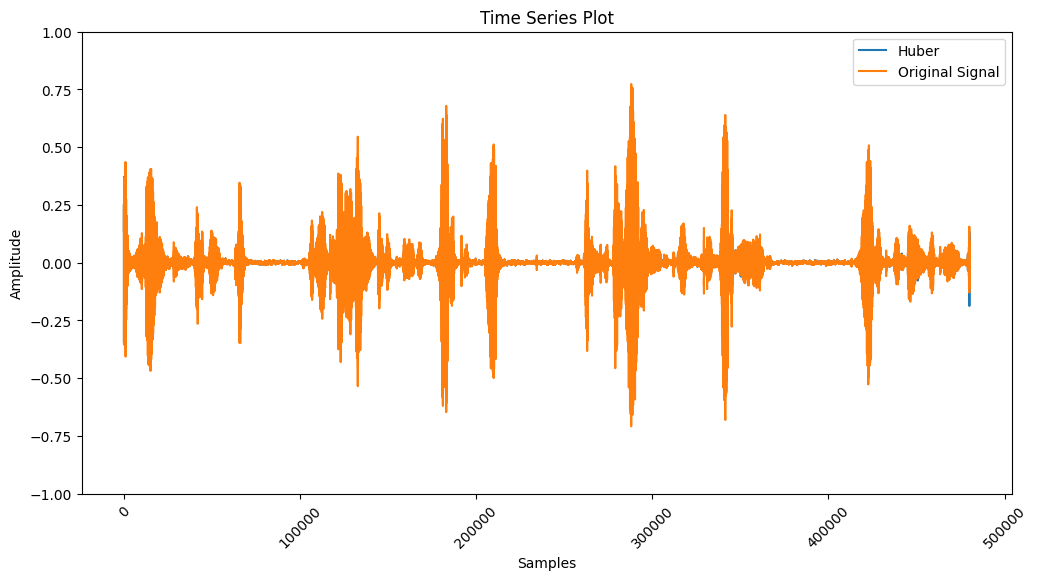

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


t = [t for t in range(len(e_huber_fdkf))]
# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x=t, y=e_huber_fdkf, label = "Huber")
sns.lineplot(x=t, y = d_1, label="Original Signal")
plt.xticks(rotation=45)
plt.title('Time Series Plot')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.ylim([-1, 1])
plt.show()

<ipython-input-1-6e1c6b7bf89d>:105: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax2.set_xlim(0, f[-1])


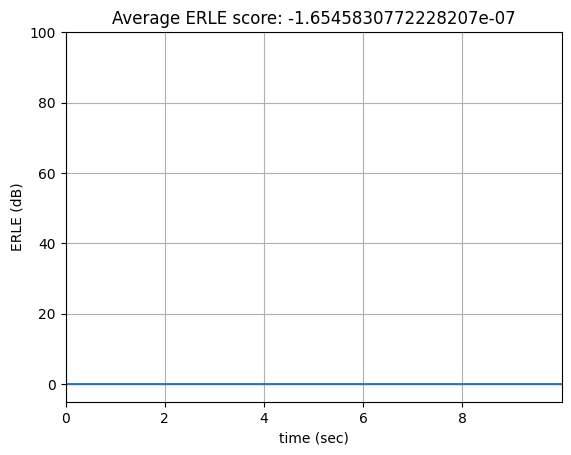

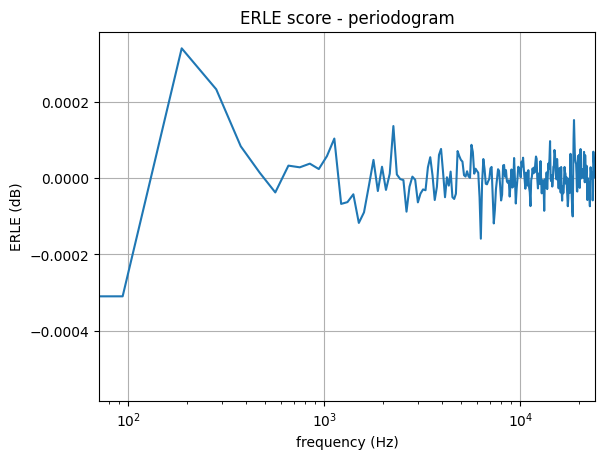

In [ ]:
erle_avg_huber, erle_huber = compute_erle(d, e_huber, sr)